Propensity score is used when there is no control group with similarity to treament group. 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy


In [2]:
dataset = pd.read_csv("lalonde.csv")
pd.set_option('display.max_columns', None)

In [3]:
dataset.groupby('treat').mean()    

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


- the treatment group and control group are very different from mean. Therefore we need to filter control group

In [5]:
# get a list of all contrinuous variables' names
continuous_confounders = ["age", "educ", "re74", "re75"]

In [9]:
# create an empty dictionary
t_test_results = {}

# loop over column_list and execute code explained above
for variable in continuous_confounders:
    group1 = dataset.where(dataset.treat== 0).dropna()[variable]
    group2 = dataset.where(dataset.treat== 1).dropna()[variable]
    t_test_results[variable] = scipy.stats.ttest_ind(group1,group2)
results = pd.DataFrame.from_dict(t_test_results,orient='Index')
results.columns = ['statistic','pvalue']
results['pvalue'] = results['pvalue'].round(3)

In [10]:
results

,statistic,pvalue
age,2.559013,0.011
educ,-0.477747,0.633
re74,6.381464,0.000
re75,3.248551,0.001


- re74, re75, age is very different but educ is not so different

In [11]:
#isolating treatment and confounders
treat = dataset.iloc[:, 0]
confounders= dataset.iloc[:, 1:-1]

In [12]:
treat

0      1
1      1
2      1
3      1
4      1
      ..
609    0
610    0
611    0
612    0
613    0
Name: treat, Length: 614, dtype: int64

In [13]:
confounders

,age,educ,black,hispan,married,nodegree,re74,re75
0,37,11,1,0,1,1,0.0,0.0
1,22,9,0,1,0,1,0.0,0.0
2,30,12,1,0,0,0,0.0,0.0
3,27,11,1,0,0,1,0.0,0.0
4,33,8,1,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...
609,18,11,0,0,0,1,0.0,0.0
610,24,1,0,1,1,1,0.0,0.0
611,21,18,0,0,0,0,0.0,0.0
612,32,5,1,0,1,1,0.0,0.0


In [14]:
#logistic regression
import statsmodels.api as sm
confounders = sm.add_constant(confounders)
propensity_model = sm.Logit(treat, confounders).fit()
propensity_model.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Fri, 02 Aug 2024   Pseudo R-squ.:                  0.3508
Time:                        14:21:43   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

- in test re74, re75 were both significant but now only re74 is significant meaning 74 and 75 are correlated

In [16]:
#predicting the propensity of being treated
propensity_score = propensity_model.predict(confounders)

In [17]:
propensity_score

0      0.638770
1      0.224634
2      0.678244
3      0.776324
4      0.701639
         ...   
609    0.123144
610    0.034560
611    0.183351
612    0.383032
613    0.089712
Length: 614, dtype: float64

- so basically use logistc regression to filter similar components to treatment 1

In [18]:
#create dataframe with treated and propensities
propensity_dataframe = np.vstack([treat, propensity_score])
propensity_dataframe = np.transpose(propensity_dataframe)

In [19]:
propensity_dataframe

array([[1.        , 0.63876993],
       [1.        , 0.22463424],
       [1.        , 0.67824388],
       ...,
       [0.        , 0.183351  ],
       [0.        , 0.3830323 ],
       [0.        , 0.08971192]])

In [20]:
df = pd.DataFrame(propensity_dataframe, columns=["label", "propensity_score"])

In [21]:
df

,label,propensity_score
0,1.0,0.638770
1,1.0,0.224634
2,1.0,0.678244
3,1.0,0.776324
4,1.0,0.701639
...,...,...
609,0.0,0.123144
610,0.0,0.034560
611,0.0,0.183351
612,0.0,0.383032


In [22]:
#finish preparations for common support region
non_treated = propensity_dataframe[:,0] == 0
non_treated = propensity_dataframe[non_treated]
non_treated = non_treated[:, 1]
treated = propensity_dataframe[:,0] == 1
treated = propensity_dataframe[treated]
treated = treated[:, 1]

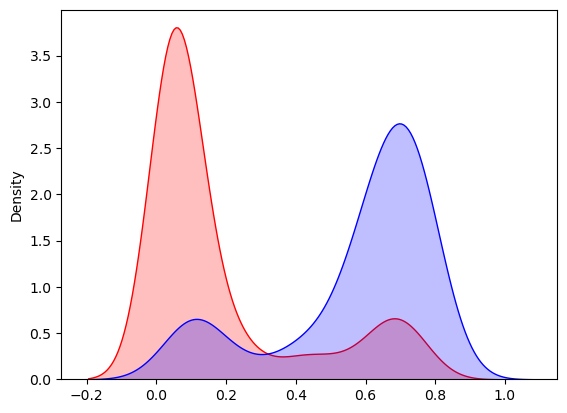

In [27]:
#Common support region
plot_non_treated = sns.kdeplot(non_treated, fill = True, color = "r")
plot_treated = sns.kdeplot(treated, fill = True, color = "b")

In [28]:
#isolating Y, treat and confounders
treat = dataset.iloc[:, 0].values #treat
confounders= dataset.iloc[:, 1:-1].values #age~75
Y = dataset.iloc[:, -1].values #re78

In [31]:
dataset

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
609,0,18,11,0,0,0,1,0.0,0.0,10150.5000
610,0,24,1,0,1,1,1,0.0,0.0,19464.6100
611,0,21,18,0,0,0,0,0.0,0.0,0.0000
612,0,32,5,1,0,1,1,0.0,0.0,187.6713


In [33]:
confounders

array([[37., 11.,  1., ...,  1.,  0.,  0.],
       [22.,  9.,  0., ...,  1.,  0.,  0.],
       [30., 12.,  1., ...,  0.,  0.,  0.],
       ...,
       [21., 18.,  0., ...,  0.,  0.,  0.],
       [32.,  5.,  1., ...,  1.,  0.,  0.],
       [16.,  9.,  0., ...,  1.,  0.,  0.]])

In [36]:
from causalinference import CausalModel
propensity_model = CausalModel(Y, treat, confounders)
propensity_model.est_propensity_s()
propensity_model.est_via_matching(bias_adj = True)
print(propensity_model.estimates)
print(propensity_model.propensity)



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -444.122   1599.269     -0.278      0.781  -3578.690   2690.446
           ATC   -722.201   2021.846     -0.357      0.721  -4685.019   3240.617
           ATT    200.720   1779.421      0.113      0.910  -3286.945   3688.385


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -21.096      2.687     -7.851      0.000    -26.363    -15.829
            X2      2.635      0.367      7.179      0.000      1.915      3.354
            X4     -3.026      0.717     -4.222      0.000     -4.431     -1.621
            X6      0.000      0.000      0.847      0.397     -0.000      0.000
            X3      5.137 

C:\Users\LGPC\anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [35]:
#!pip install causalinference

     ---------------------------------------- 51.1/51.1 kB 2.6 MB/s eta 0:00:00
